# <span style="color:orange">June Exam 2024</span>

In [139]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [140]:
df = pd.read_csv('adult.csv/adult.csv')

## <span style="color:orange">Step 1: Load and Explore the Dataset</span>

In [142]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [144]:
catcols = ['workclass','education','marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income']

In [145]:
print(df.isnull().sum())

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64


### Check for '?' symbols in categorical columns

In [147]:
print((df == '?').sum())

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64


# <span style="color:orange">Step 2: Handling Missing Values</span>

### Replace '?' with NaN

In [150]:
df.replace('?', np.nan, inplace=True)

In [151]:
((df=="?").sum())

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

### Count missing values again

In [153]:
print(df.isnull().sum())

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64


### Percentage of missing values per column

In [155]:
missing_percentage = df.isnull().sum() / len(df) * 100
print(missing_percentage)

age               0.000000
workclass         5.638647
fnlwgt            0.000000
education         0.000000
education.num     0.000000
marital.status    0.000000
occupation        5.660146
relationship      0.000000
race              0.000000
sex               0.000000
capital.gain      0.000000
capital.loss      0.000000
hours.per.week    0.000000
native.country    1.790486
income            0.000000
dtype: float64


### Drop 'fnlwgt' since it's not useful

In [157]:
df.drop(columns=['fnlwgt'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   education       32561 non-null  object
 3   education.num   32561 non-null  int64 
 4   marital.status  32561 non-null  object
 5   occupation      30718 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital.gain    32561 non-null  int64 
 10  capital.loss    32561 non-null  int64 
 11  hours.per.week  32561 non-null  int64 
 12  native.country  31978 non-null  object
 13  income          32561 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.5+ MB


# <span style="color:orange">Step 3: Handling Missing Values in Categorical Columns Using KNNImputer</span>

### Select categorical columns with missing values

In [160]:
categorical_cols = df.select_dtypes(include=['object']).columns

missing_categorical = [col for col in categorical_cols if df[col].isnull().sum() > 0]

### Encode categorical variables to numerical values

In [162]:
df.head(2)

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K


In [163]:
label_encoders = {}
le = LabelEncoder()

for col in missing_categorical:
    df[col] = le.fit_transform(df[col].astype(str))

for col in missing_categorical:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Convert NaN to string to avoid errors
    label_encoders[col] = le  # Store the encoder for inverse transformation

In [164]:
df.head(2)

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,8,HS-grad,9,Widowed,6,Not-in-family,White,Female,0,4356,40,32,<=50K
1,82,3,HS-grad,9,Widowed,8,Not-in-family,White,Female,0,4356,18,32,<=50K


In [165]:
imputer = KNNImputer(n_neighbors=5)
df[missing_categorical] = imputer.fit_transform(df[missing_categorical])

#   for column in columns:
#     data_copy[column] = imputer.fit_transform(data_copy[column].to_numpy().reshape(-1, 1))
#   return data_copy

In [166]:
missing_categorical

['workclass', 'occupation', 'native.country']

### Convert back to original categorical labels

In [168]:
for col in missing_categorical:
    df[col] = label_encoders[col].inverse_transform(df[col].astype(int))

In [169]:
df.head(2)

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,8,HS-grad,9,Widowed,14,Not-in-family,White,Female,0,4356,40,38,<=50K
1,82,3,HS-grad,9,Widowed,3,Not-in-family,White,Female,0,4356,18,38,<=50K


In [170]:
missing_categorical

['workclass', 'occupation', 'native.country']

### Check if missing values are handled

In [172]:
print(df.isnull().sum())

age               0
workclass         0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64


# <span style="color:orange">Step 5: Analyzing the Salary Distribution</span>


### Count of each salary category

In [175]:
df.income.unique()

array(['<=50K', '>50K'], dtype=object)

In [176]:
df['income'].value_counts()


income
<=50K    24720
>50K      7841
Name: count, dtype: int64

In [177]:
salary_counts = df['income'].value_counts()
total_citizens = len(df)
percentage_above_50k = (salary_counts['>50K'] / total_citizens) * 100

print(f"Percentage of citizens earning more than $50K: {percentage_above_50k:.2f}%")

Percentage of citizens earning more than $50K: 24.08%


### Visualization

<Axes: xlabel='income'>

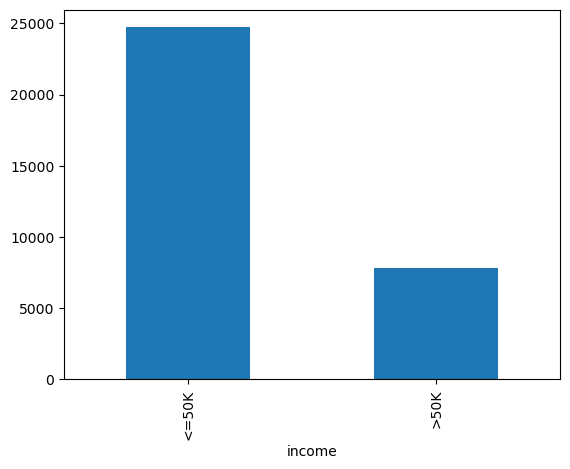

In [179]:
df['income'].value_counts().plot.bar()

# <span style="color:orange">Step 5: Checking if Education Influences Yearly Income</span>


### Group by education and calculate percentage earning >50K

In [182]:
education_salary = df.groupby('education')['income'].value_counts(normalize=True).unstack()

education_salary['>50K'] = education_salary['>50K'] * 100  # Convert to percentage

education_salary = education_salary.sort_values(by='>50K', ascending=False) # Sort values for better visualization

### Plot

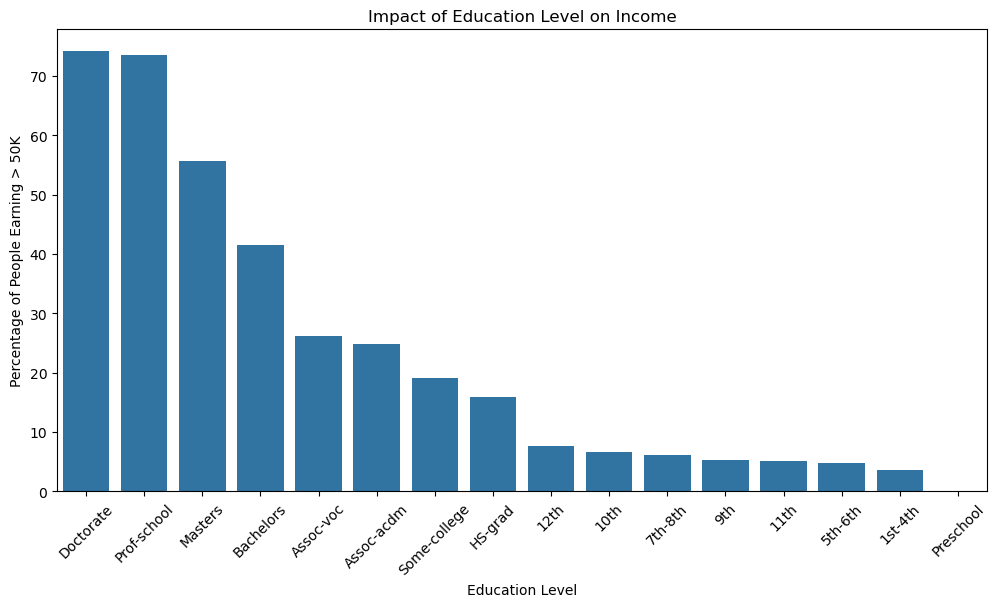

In [184]:
plt.figure(figsize=(12, 6))
sns.barplot(x=education_salary.index, y=education_salary['>50K'])
plt.xticks(rotation=45)
plt.xlabel("Education Level")
plt.ylabel("Percentage of People Earning > 50K")
plt.title("Impact of Education Level on Income")
plt.show()

# Step 6: Analyzing Income Differences Between Age Groups (41-50 vs. 51-60)

### Define age groups

In [187]:
# returns a table where the rows match the age criteria
df_age_group_41_50 = df[(df['age'] >= 41) & (df['age'] <= 50)]
df_age_group_51_60 = df[(df['age'] >= 51) & (df['age'] <= 60)]

### Calculate percentage earning >50K in each group

In [189]:
percentage_41_50 = (df_age_group_41_50['income'].value_counts(normalize=True)['>50K']) * 100
percentage_51_60 = (df_age_group_51_60['income'].value_counts(normalize=True)['>50K']) * 100

### Data for visualization

In [191]:
age_groups = ['41-50', '51-60']
percentages = [percentage_41_50, percentage_51_60]

In [192]:
print(f"Percentage 41-50 earning > 50k: {percentages[0]:.2f}")
print(f"Percentage 51-60 earning > 50k: {percentages[1]:.2f}")

Percentage 41-50 earning > 50k: 38.02
Percentage 51-60 earning > 50k: 37.48


### Plot

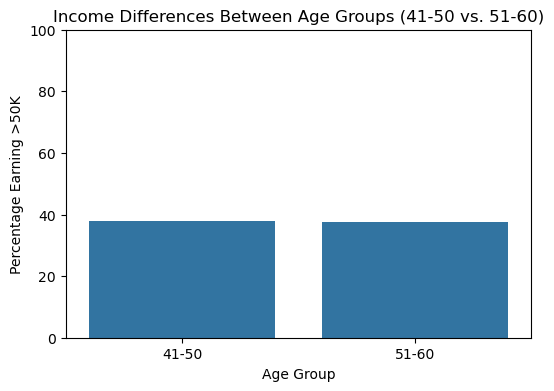

In [194]:
plt.figure(figsize=(6, 4))
sns.barplot(x=age_groups, y=percentages)
plt.xlabel("Age Group")
plt.ylabel("Percentage Earning >50K")
plt.title("Income Differences Between Age Groups (41-50 vs. 51-60)")
plt.ylim(0, 100)
plt.show()

### Print values

In [196]:
print(f"Percentage of people aged 41-50 earning >50K: {percentage_41_50:.2f}%")
print(f"Percentage of people aged 51-60 earning >50K: {percentage_51_60:.2f}%")

Percentage of people aged 41-50 earning >50K: 38.02%
Percentage of people aged 51-60 earning >50K: 37.48%


- The difference in the percentage of people earning more than $50K

between the age groups 41-50 and 51-60 is quite small (38.02% vs. 37.48%),

which suggests that age might not be a major factor influencing the likelihood 

of earning more than $50K in these two groups.

# Step 7: Analyzing the Relationship Between Weekly Working Hours and Income

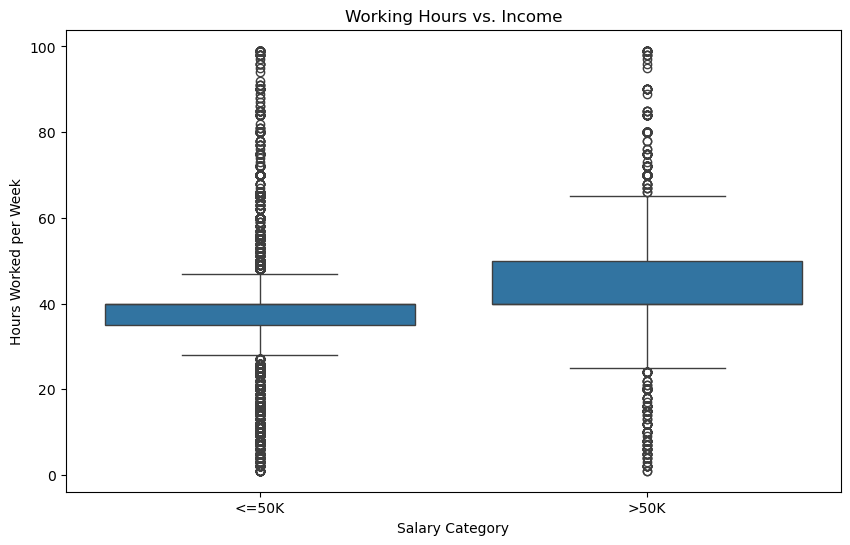


Average Working Hours per Week by Salary Group:
income
<=50K    38.840210
>50K     45.473026
Name: hours.per.week, dtype: float64


In [199]:
# Plot working hours vs. income
plt.figure(figsize=(10, 6))
sns.boxplot(x='income', y='hours.per.week', data=df)
plt.xlabel("Salary Category")
plt.ylabel("Hours Worked per Week")
plt.title("Working Hours vs. Income")
plt.show()

# Calculate the average working hours for each salary group
average_hours = df.groupby('income')['hours.per.week'].mean()
print("\nAverage Working Hours per Week by Salary Group:")
print(average_hours)


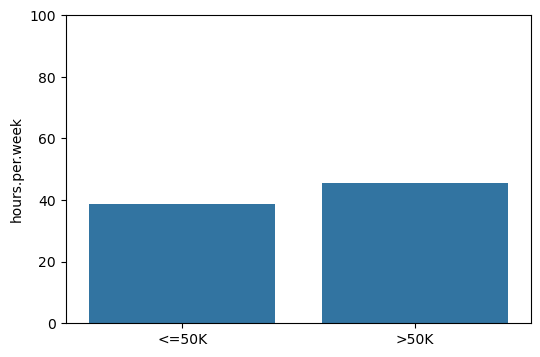

In [200]:
plt.figure(figsize=(6,4))
sns.barplot(x=['<=50K', '>50K'], y=average_hours)
plt.ylim(0,100)
plt.show()

- People earning ≤ 50K per year work an average of 38.84 hours per
week (slightly below the standard 40-hour workweek).

# Step 5: Feature Selection for Modeling

In [203]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Select features
features = ['workclass', 'occupation', 'hours.per.week', 'income', 'age', 'sex']
target = 'education.num'

In [204]:
# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le



# for col in catcols:
#     le = LabelEncoder()
#     df[col] = le.fit_transform(df[col])
#     label_encoders[col] = le

In [205]:
# Split data
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Model 1 - XGBoost (Boosting Model)

In [207]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [208]:
from xgboost import XGBRegressor

# Train XGBRegressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1)

model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)




In [209]:
# Evaluation
mae_xgb = mean_absolute_error(y_test, y_pred)
r2_xgb = r2_score(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"mse: {mse:.2f}")
print(f"mae: {mae:.2f}")
print(f"r2: {r2:.2f}")

mse: 4.03
mae: 1.44
r2: 0.38


In [210]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = rf_model.predict(X_test)
print("RandomForest Metrics:", mean_absolute_error(y_test, y_pred_rf), mean_squared_error(y_test, y_pred_rf), r2_score(y_test, y_pred_rf))

RandomForest Metrics: 1.5932298683260353 4.754927071212833 0.26313234072165215


# Clustering

In [212]:
clustering_data = df.drop(columns=[ 'capital.gain', 'capital.loss', 'native.country'])

In [213]:
clustering_data.columns

Index(['age', 'workclass', 'education', 'education.num', 'marital.status',
       'occupation', 'relationship', 'race', 'sex', 'hours.per.week',
       'income'],
      dtype='object')

In [214]:
# Finding optimal clusters
inertias = []
iterations = range(2, 10)

for k in iterations:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data)
    inertias.append(np.sqrt(kmeans.inertia_))

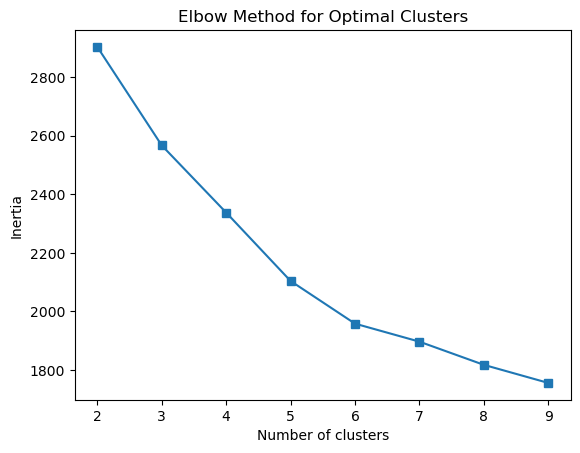

In [216]:
plt.plot(iterations, inertias, marker='s')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [218]:
from kneed import KneeLocator

knee_locator = KneeLocator(iterations, inertias, curve="convex", direction="decreasing")

print(f"k: {knee_locator.knee}, WSS: {inertias[knee_locator.knee - 1]}")

k: 5, WSS: 1958.2912314860248


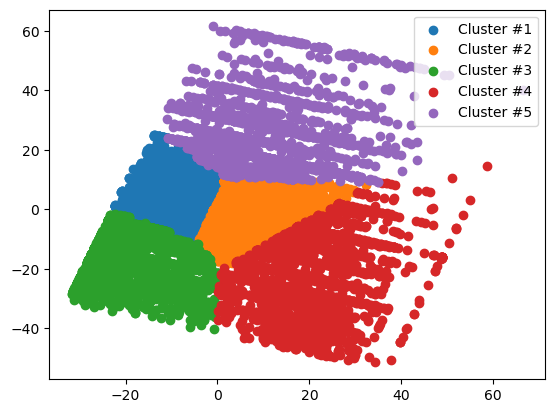

In [228]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(clustering_data)

labels = KMeans(init="k-means++", n_clusters=5, random_state=42).fit_predict(reduced_data)

for label in np.unique(labels):
    plt.scatter(
        reduced_data[labels == label, 0],
        reduced_data[labels == label, 1],
        label=f"Cluster #{label + 1}"
    )
    plt.legend()